## Initialization

### Importing Libraries

In [ ]:
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# to use the same matplotlib backend as Jupyter uses, so any GUI will shown
%matplotlib inline

# Feature Engineering
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

# Imbalance Dataset
from imblearn.over_sampling import SMOTE

# Modeling
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
# from sklearn.metrics import classification_report #, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# Evaluate
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

### User-defined Functions

In [ ]:
def val_count(data:pd.Series, orderby:str='Count', ascending:bool=False) -> pd.DataFrame:
    '''
    Return a DataFrame containing counts of unique rows in Series

    Parameters
    ----------
    data: Series
        the data to be displayed value counts
    orderby: str (Count or Values)
        how to order the data, default Count
    ascending: bool (default: False)
        True for ascending, False for descending

    Returns
    ------
    DataFrame
        - Values : Values name
        - Count : Count per value
        - % : Percentage of count
    '''
    if type(data) == pd.Series:
        result = data.value_counts(dropna=False).reset_index() # without drop
        result.columns = ['Values', 'Count']
        result['%'] = np.around(result['Count'] * 100/len(data), 3)
        return result.sort_values(by=orderby, ascending=ascending)
    else:
        return 'Input Series only'

In [ ]:
def numerical_summary(data: pd.Series, n: int = 3) -> pd.Series:
    '''
    Statistics summary for numerical data.

    Parameters
    ----------
    data : pandas series
        the data to be displayed in summary
    n : int, optional
        determine the number after the comma of the result
    '''

    # central tendency: mean, median
    mean = np.mean(data)
    median = np.median(data)

    # # distribution: std, min, max, range, skew, kurtosis
    std = np.std(data)
    min_value = np.min(data)
    max_value = np.max(data)
    range_value = np.abs(max_value - min_value)
    skewness = data.skew()
    kurtosis = data.kurtosis()

    # # concatenates
    result = pd.Series([min_value, max_value, range_value, mean, median, std, skewness, kurtosis])
    result.index = ['min','max', 'range','mean','median',  'std','skewness','kurtosis']

    return np.around(result, n)
    # return mean

## Data Collecting

In [ ]:
path = '/content/sample_data/Dataset of Diabetes.csv'
data = pd.read_csv(path)
data

,ID,No_Pation,Gender,AGE,Urea,Cr,HbA1c,Chol,TG,HDL,LDL,VLDL,BMI,CLASS
0,502,17975,F,50,4.7,46,4.9,4.2,0.9,2.4,1.4,0.5,24.0,N
1,735,34221,M,26,4.5,62,4.9,3.7,1.4,1.1,2.1,0.6,23.0,N
2,420,47975,F,50,4.7,46,4.9,4.2,0.9,2.4,1.4,0.5,24.0,N
3,680,87656,F,50,4.7,46,4.9,4.2,0.9,2.4,1.4,0.5,24.0,N
4,504,34223,M,33,7.1,46,4.9,4.9,1.0,0.8,2.0,0.4,21.0,N
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,200,454317,M,71,11.0,97,7.0,7.5,1.7,1.2,1.8,0.6,30.0,Y
996,671,876534,M,31,3.0,60,12.3,4.1,2.2,0.7,2.4,15.4,37.2,Y
997,669,87654,M,30,7.1,81,6.7,4.1,1.1,1.2,2.4,8.1,27.4,Y
998,99,24004,M,38,5.8,59,6.7,5.3,2.0,1.6,2.9,14.0,40.5,Y


In [ ]:
jumlah_Y = data['CLASS'].value_counts()['Y']

print(f"Jumlah nilai Y di fitur 'CLASS': {jumlah_Y}")

# Menghitung jumlah nilai N pada kolom 'CLASS'
jumlah_N = data['CLASS'].value_counts()['N']

print(f"Jumlah nilai N di fitur 'CLASS': {jumlah_N}")

jumlah_P = data['CLASS'].value_counts()['P']

print(f"Jumlah nilai P di fitur 'CLASS': {jumlah_P}")

Jumlah nilai Y di fitur 'CLASS': 840
Jumlah nilai N di fitur 'CLASS': 102
Jumlah nilai P di fitur 'CLASS': 53


## Data Cleaning and Preprocessing

### Removing Unnecessary Data

In [ ]:
print(f'Columns Before ({len(data.columns)}):', data.columns.tolist())
data.drop(['ID','No_Pation'], axis=1, inplace=True)
print(f'Columns After ({len(data.columns)}):', data.columns.tolist())

Columns Before (14): ['ID', 'No_Pation', 'Gender', 'AGE', 'Urea', 'Cr', 'HbA1c', 'Chol', 'TG', 'HDL', 'LDL', 'VLDL', 'BMI', 'CLASS']
Columns After (12): ['Gender', 'AGE', 'Urea', 'Cr', 'HbA1c', 'Chol', 'TG', 'HDL', 'LDL', 'VLDL', 'BMI', 'CLASS']


### Correcting Data Entry Errors

In [ ]:
print('# Before')
for col in data.select_dtypes('object').columns:
    print(f'{col}: {data[col].unique().tolist()}')

# Before
Gender: ['F', 'M', 'f']
CLASS: ['N', 'N ', 'P', 'Y', 'Y ']


In [ ]:
data['Gender'] =  data['Gender'].replace({'f': 'F'})
data['CLASS'] =  data['CLASS'].replace({'N ': 'N', 'P': 'Y', 'Y ': 'Y'})

In [ ]:
print('# After')
for col in data.select_dtypes('object').columns:
    print(f'{col}: {data[col].unique().tolist()}')

# After
Gender: ['F', 'M']
CLASS: ['N', 'Y']


### Handling Missing Value

In [ ]:
data.isna().sum()

,0
Gender,0
AGE,0
Urea,0
Cr,0
HbA1c,0
Chol,0
TG,0
HDL,0
LDL,0
VLDL,0


### Dealing with Duplicate Records

In [ ]:
print('Records Before:', len(data))
data = data.drop_duplicates().reset_index(drop=True)
print('Records After:', len(data))

Records Before: 1000
Records After: 826


### Data Transformation

#### Encode Gender

In [ ]:
print('Before:', data['Gender'].unique().tolist())
data['Gender'].replace({'F': 0, 'M': 1}, inplace=True)
print('After:', data['Gender'].unique().tolist())

Before: ['F', 'M']
After: [0, 1]


<ipython-input-12-3cbfbb28a7a2>:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['Gender'].replace({'F': 0, 'M': 1}, inplace=True)
<ipython-input-12-3cbfbb28a7a2>:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data['Gender'].replace({'F': 0, 'M': 1}, inplace=True)


#### Encode CLASS

In [ ]:
print('Before:', data['CLASS'].unique().tolist())
data['CLASS'].replace({'N': 0, 'Y': 1}, inplace=True)
print('After:', data['CLASS'].unique().tolist())

Before: ['N', 'Y']
After: [0, 1]


<ipython-input-13-d615e2511714>:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['CLASS'].replace({'N': 0, 'Y': 1}, inplace=True)
<ipython-input-13-d615e2511714>:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data['CLASS'].replace({'N': 0, 'Y': 1}, inplace=True)


## Data Exploration

### Univariate Analysis (Categorical)

#### Gender

In [ ]:
gender = val_count(data.Gender)
gender.style.hide(axis='index')

Values,Count,%
1,463,56.053000
0,363,43.947000


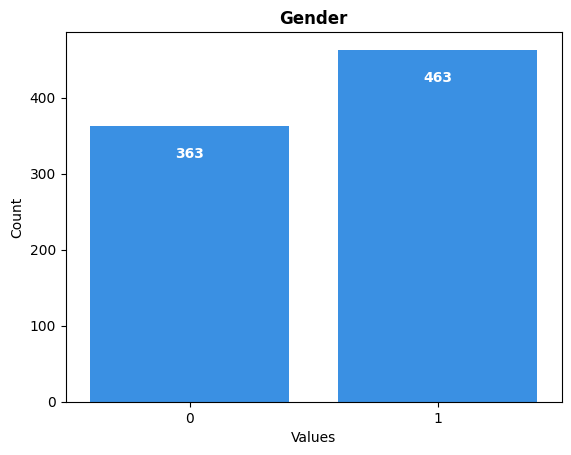

In [ ]:
ax = sns.barplot(data=gender, x='Values', y='Count', color='dodgerblue')
ax.bar_label(ax.containers[0], fmt='%i', padding=-25, color='white', fontweight='bold')
plt.title('Gender', fontweight='bold')
plt.show()

### Univariate Analysis (Numerical)

#### AGE

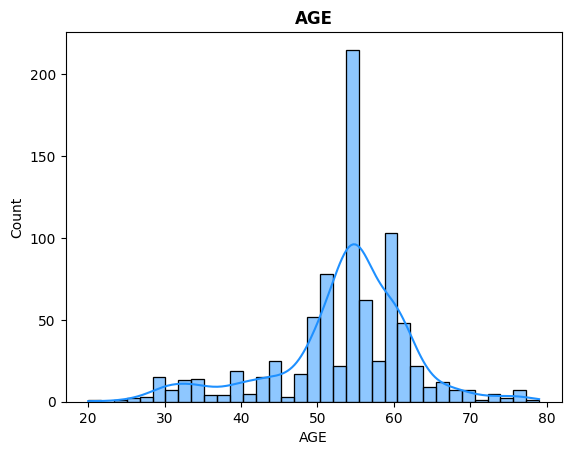

In [ ]:
sns.histplot(data['AGE'], kde=True, color='dodgerblue')
plt.title('AGE', fontweight='bold')
plt.show()

In [ ]:
numerical_summary(data['AGE'])

,0
min,20.000
max,79.000
range,59.000
mean,53.490
median,55.000
std,8.803
skewness,-0.811
kurtosis,1.446


#### Urea

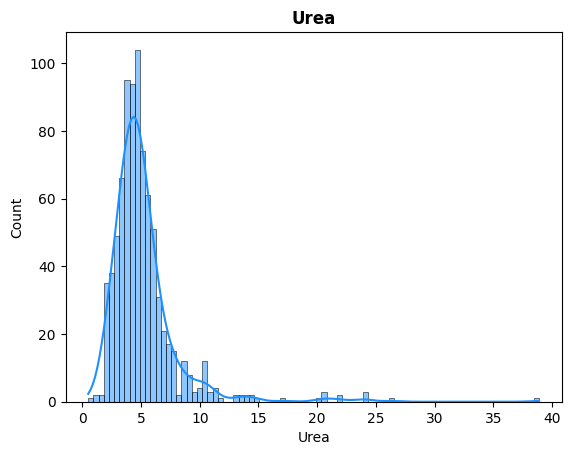

In [ ]:
sns.histplot(data['Urea'], kde=True, color='dodgerblue')
plt.title('Urea', fontweight='bold')
plt.show()

In [ ]:
numerical_summary(data['Urea'])

,0
min,0.500
max,38.900
range,38.400
mean,5.185
median,4.600
std,3.076
skewness,4.259
kurtosis,29.197


#### Cr

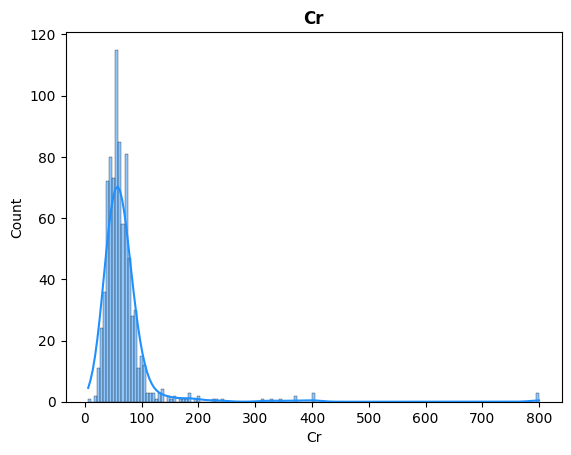

In [ ]:
sns.histplot(data['Cr'], kde=True, color='dodgerblue')
plt.title('Cr', fontweight='bold')
plt.show()

In [ ]:
numerical_summary(data['Cr'])

,0
min,6.000
max,800.000
range,794.000
mean,69.024
median,59.000
std,59.521
skewness,8.149
kurtosis,87.035


#### HbA1c

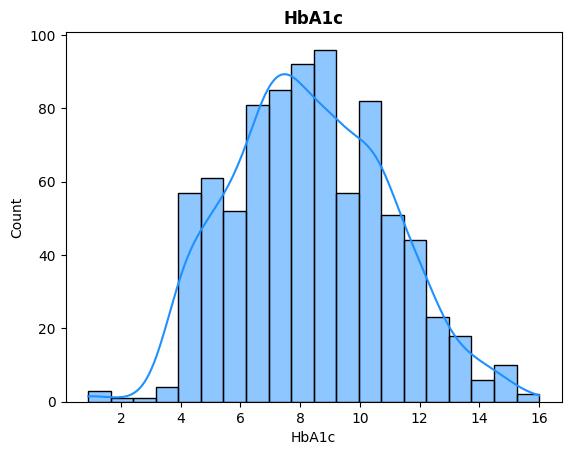

In [ ]:
sns.histplot(data['HbA1c'], kde=True, color='dodgerblue')
plt.title('HbA1c', fontweight='bold')
plt.show()

In [ ]:
numerical_summary(data['HbA1c'])

,0
min,0.900
max,16.000
range,15.100
mean,8.326
median,8.100
std,2.601
skewness,0.183
kurtosis,-0.340


#### Chol

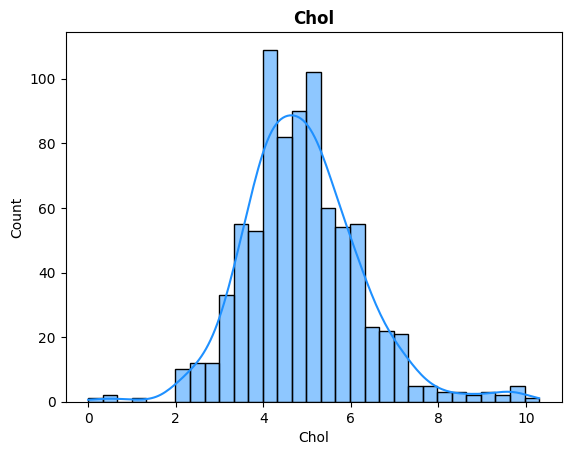

In [ ]:
sns.histplot(data['Chol'], kde=True, color='dodgerblue')
plt.title('Chol', fontweight='bold')
plt.show()

In [ ]:
numerical_summary(data['Chol'])

,0
min,0.000
max,10.300
range,10.300
mean,4.898
median,4.800
std,1.328
skewness,0.576
kurtosis,1.696


#### TG

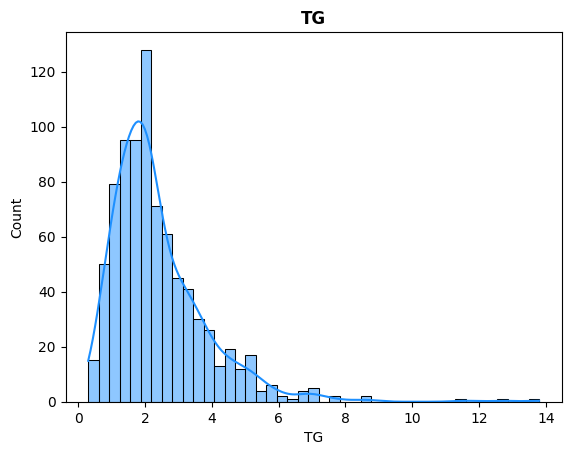

In [ ]:
sns.histplot(data['TG'], kde=True, color='dodgerblue')
plt.title('TG', fontweight='bold')
plt.show()

In [ ]:
numerical_summary(data['TG'])

,0
min,0.300
max,13.800
range,13.500
mean,2.399
median,2.015
std,1.456
skewness,2.295
kurtosis,10.144


#### HDL

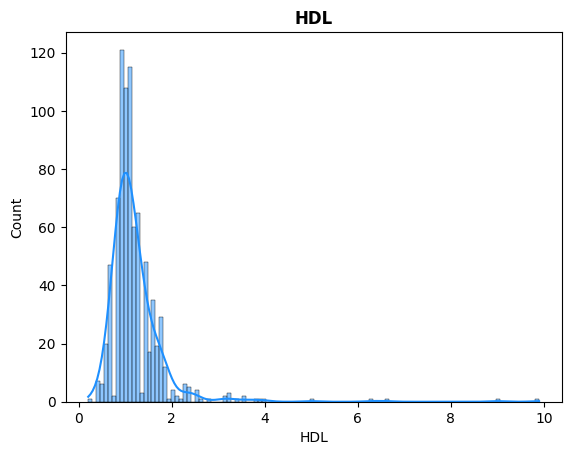

In [ ]:
sns.histplot(data['HDL'], kde=True, color='dodgerblue')
plt.title('HDL', fontweight='bold')
plt.show()

In [ ]:
numerical_summary(data['HDL'])

,0
min,0.200
max,9.900
range,9.700
mean,1.212
median,1.100
std,0.679
skewness,6.298
kurtosis,62.700


#### LDL

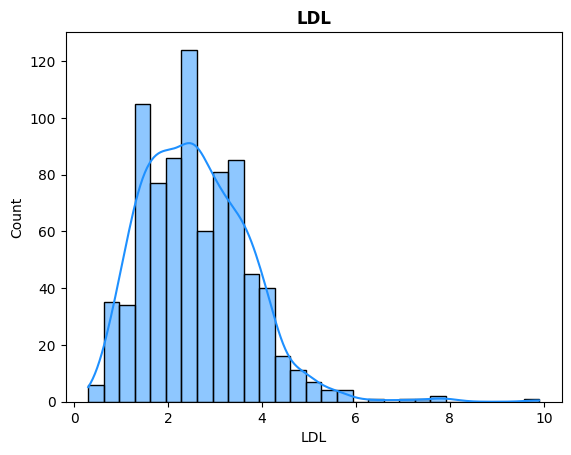

In [ ]:
sns.histplot(data['LDL'], kde=True, color='dodgerblue')
plt.title('LDL', fontweight='bold')
plt.show()

In [ ]:
numerical_summary(data['LDL'])

,0
min,0.300
max,9.900
range,9.600
mean,2.590
median,2.500
std,1.132
skewness,1.005
kurtosis,3.023


#### VLDL

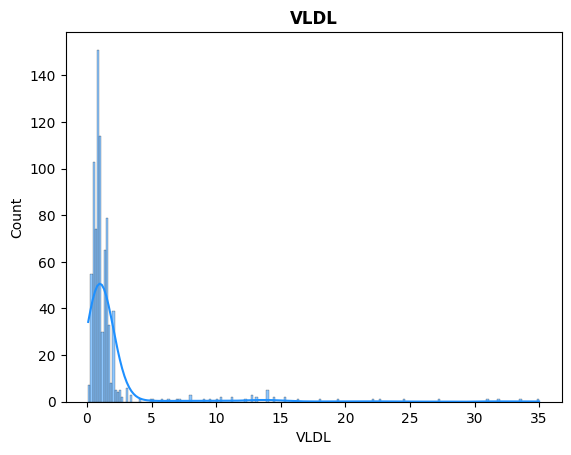

In [ ]:
sns.histplot(data['VLDL'], kde=True, color='dodgerblue')
plt.title('VLDL', fontweight='bold')
plt.show()

In [ ]:
numerical_summary(data['VLDL'])

,0
min,0.100
max,35.000
range,34.900
mean,1.775
median,1.000
std,3.516
skewness,5.893
kurtosis,40.185


#### BMI

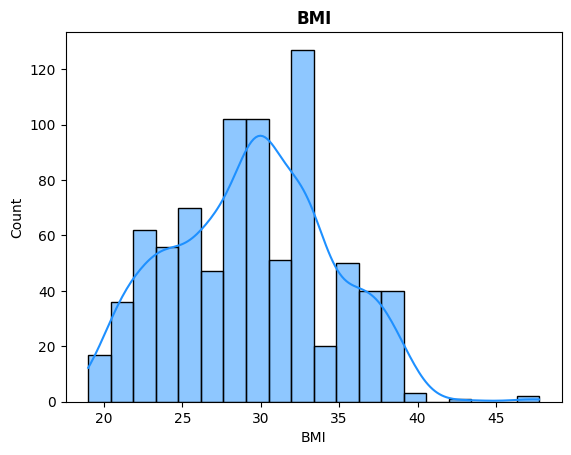

In [ ]:
sns.histplot(data['BMI'], kde=True, color='dodgerblue')
plt.title('BMI', fontweight='bold')
plt.show()

In [ ]:
numerical_summary(data['BMI'])

,0
min,19.000
max,47.750
range,28.750
mean,29.459
median,30.000
std,4.994
skewness,0.081
kurtosis,-0.425


### Correlation

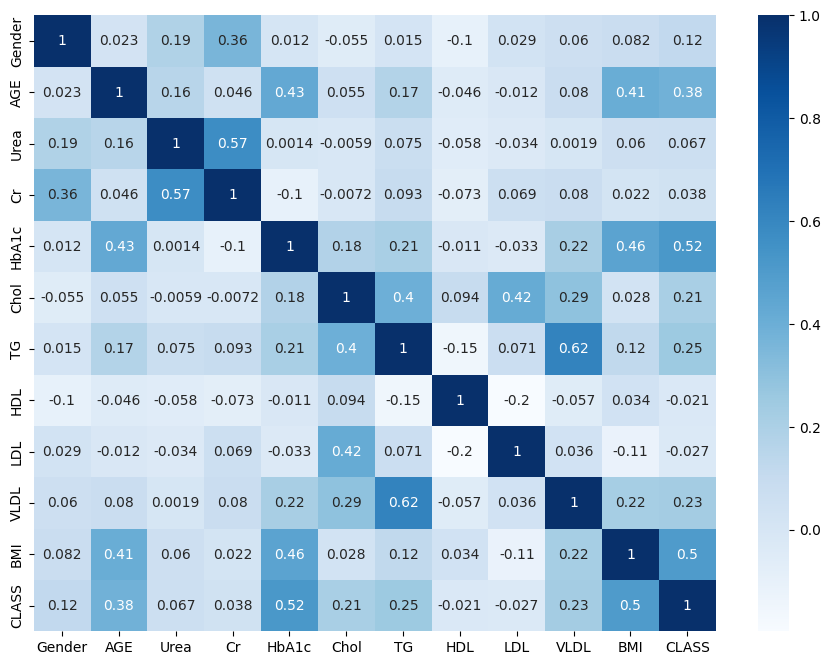

In [ ]:
plt.figure(figsize=(11,8))
sns.heatmap(data.corr(method='spearman'), annot=True, cmap='Blues')
plt.show()

In [ ]:
corr_with_target = data.drop('CLASS', axis=1).corrwith(data['CLASS'],axis=0, method='spearman')
corr_with_target = corr_with_target.sort_values(key=abs, ascending=False).reset_index()
corr_with_target = corr_with_target.rename(columns={'index':'Feature', 0:'Corr'})
print('Sorted Correlation Between Feature and Target(CLASS)\n')
display(corr_with_target.style.hide(axis='index'))

Sorted Correlation Between Feature and Target(CLASS)



Feature,Corr
HbA1c,0.521619
BMI,0.502826
AGE,0.383285
TG,0.253221
VLDL,0.231634
Chol,0.212505
Gender,0.120338
Urea,0.067122
Cr,0.038377
LDL,-0.026866


### Label Distributions

In [ ]:
class_ = val_count(data.CLASS)
class_.style.hide(axis='index')

Values,Count,%
1,730,88.378000
0,96,11.622000


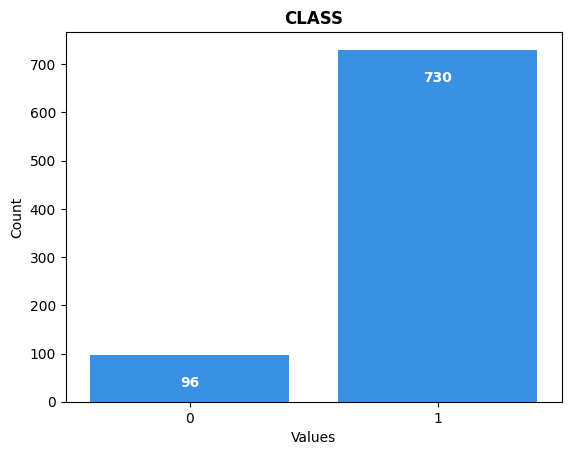

In [ ]:
ax = sns.barplot(data=class_, x='Values', y='Count', color='dodgerblue')
ax.bar_label(ax.containers[0], fmt='%i', padding=-25, color='white', fontweight='bold')
plt.title('CLASS', fontweight='bold')
plt.show()

## Feature Engineering

### Normalizing

In [ ]:
norm_col = ['AGE', 'Urea', 'Cr', 'HbA1c', 'Chol', 'TG', 'HDL', 'LDL', 'VLDL', 'BMI']
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data[norm_col])
data_scaled = pd.DataFrame(data_scaled, columns=norm_col)
data = pd.concat([data_scaled, data[['Gender', 'CLASS']]], axis=1)
data

,AGE,Urea,Cr,HbA1c,Chol,TG,HDL,LDL,VLDL,BMI,Gender,CLASS
0,0.508475,0.109375,0.050378,0.264901,0.407767,0.044444,0.226804,0.114583,0.011461,0.173913,0,0
1,0.101695,0.104167,0.070529,0.264901,0.359223,0.081481,0.092784,0.187500,0.014327,0.139130,1,0
2,0.220339,0.171875,0.050378,0.264901,0.475728,0.051852,0.061856,0.177083,0.008596,0.069565,1,0
3,0.423729,0.046875,0.022670,0.205298,0.281553,0.051852,0.082474,0.125000,0.008596,0.069565,0,0
4,0.508475,0.039062,0.055416,0.205298,0.349515,0.074074,0.072165,0.187500,0.014327,0.173913,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
821,0.627119,0.093750,0.080605,0.556291,0.514563,0.222222,0.082474,0.114583,0.034384,0.347826,0,1
822,0.593220,0.067708,0.041562,0.503311,0.485437,0.162963,0.175258,0.270833,0.017192,0.278261,1,1
823,0.135593,0.078125,0.069270,0.503311,0.436893,0.118519,0.092784,0.239583,0.020057,0.626087,1,1
824,0.830508,0.255208,0.225441,0.450331,0.475728,0.118519,0.103093,0.281250,0.017192,0.626087,1,1


### Train-Test Split

In [ ]:
X = data.drop('CLASS', axis=1)
y = data['CLASS']



In [ ]:
import numpy as np

# Menampilkan ukuran dataset
print(f"Ukuran total data: {len(X)}")
print(f"Ukuran data latih (X_train): {len(X_train)} ({len(X_train) / len(X) * 100:.2f}%)")
print(f"Ukuran data uji (X_test): {len(X_test)} ({len(X_test) / len(X) * 100:.2f}%)")

# Jika ingin memeriksa label (y_train, y_test)
print(f"Ukuran label latih (y_train): {len(y_train)} ({len(y_train) / len(y) * 100:.2f}%)")
print(f"Ukuran label uji (y_test): {len(y_test)} ({len(y_test) / len(y) * 100:.2f}%)")

# Menampilkan distribusi kategori untuk data latih
train_counts = np.bincount(y_train)
train_ratios = train_counts / len(y_train) * 100
print("\nDistribusi data latih:")
for i, (count, ratio) in enumerate(zip(train_counts, train_ratios)):
    print(f"  Kategori {i}: {count} ({ratio:.2f}%)")

# Menampilkan distribusi kategori untuk data uji
test_counts = np.bincount(y_test)
test_ratios = test_counts / len(y_test) * 100
print("\nDistribusi data uji:")
for i, (count, ratio) in enumerate(zip(test_counts, test_ratios)):
    print(f"  Kategori {i}: {count} ({ratio:.2f}%)")



Ukuran total data: 826
Ukuran data latih (X_train): 660 (79.90%)
Ukuran data uji (X_test): 166 (20.10%)
Ukuran label latih (y_train): 660 (79.90%)
Ukuran label uji (y_test): 166 (20.10%)

Distribusi data latih:
  Kategori 0: 77 (11.67%)
  Kategori 1: 583 (88.33%)

Distribusi data uji:
  Kategori 0: 19 (11.45%)
  Kategori 1: 147 (88.55%)


### Resampling Data for Imbalance Dataset


### SMOTE-Tomek ###
Data sebelum SMOTE-Tomek: [ 73 587]


<ipython-input-42-a20bced02bfd>:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=classes, y=counts, palette=colors)


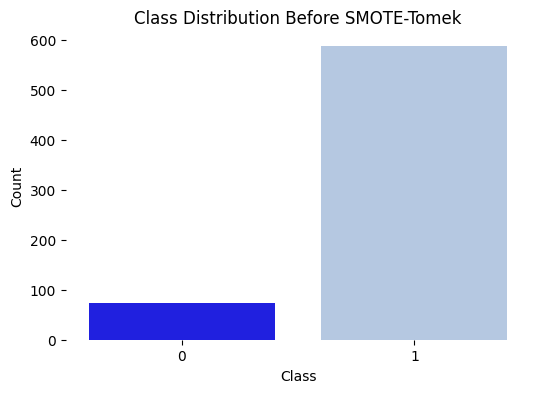

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The SMOTETomek or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.vali

Data setelah SMOTE-Tomek: [586 586]


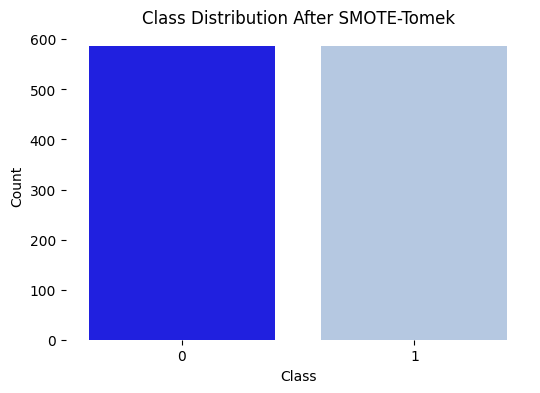

/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The SMOTETomek or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The SMOTETomek or classes from which it inherits use `_get_tags` and `_more_tags`. Please define


### SMOTEENN ###
Data sebelum SMOTEENN: [ 73 587]


<ipython-input-42-a20bced02bfd>:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=classes, y=counts, palette=colors)


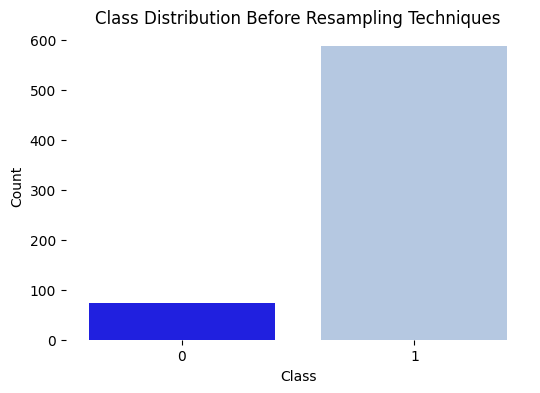

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The SMOTEENN or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.valida

Data setelah SMOTEENN: [586 535]


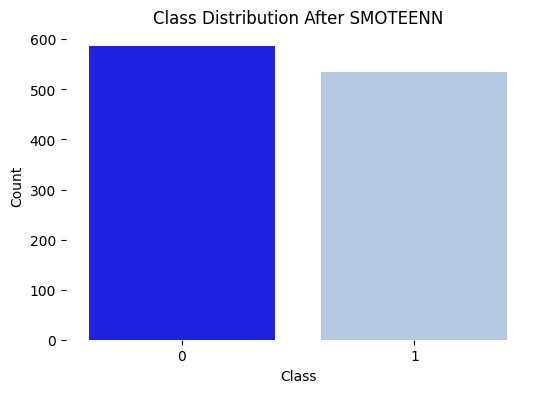

/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The SMOTEENN or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The SMOTEENN or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the


### SMOTENC ###
Data sebelum SMOTENC: [ 73 587]


<ipython-input-42-a20bced02bfd>:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=classes, y=counts, palette=colors)


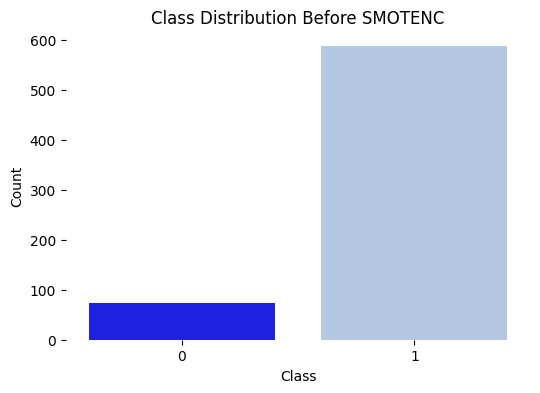

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:484: FutureWarning: `BaseEstimator._check_n_features` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_n_features` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: FutureWarning: `BaseEstimator._check_feature_names` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_feature_names` instead.
  warnings.warn(
<ipython-input-42-a20bced02bfd>:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=classes, y=counts, palette=colors)


Data setelah SMOTENC: [587 587]


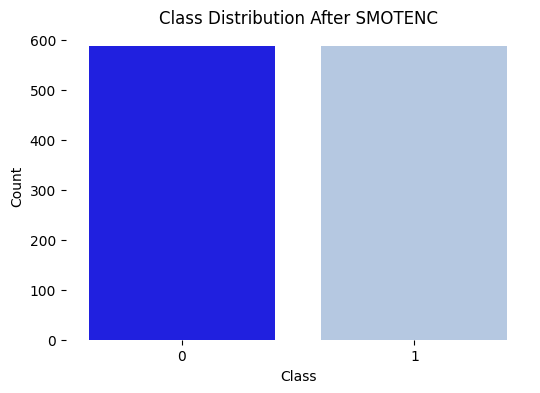

/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The SMOTENC or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:484: FutureWarning: `BaseEstimator._check_n_features` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_n_features` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: FutureWarning: `BaseEstimator._check_feature_names` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_feature_names` instead.
  warnings.warn(



### TomekLinks ###
Data sebelum TomekLinks: [ 73 587]


<ipython-input-42-a20bced02bfd>:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=classes, y=counts, palette=colors)


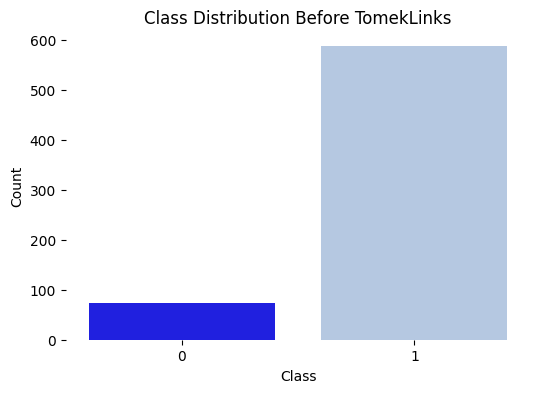

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The TomekLinks or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
<ipython-input-42-a20bced02bfd>:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and s

Data setelah TomekLinks: [ 73 577]


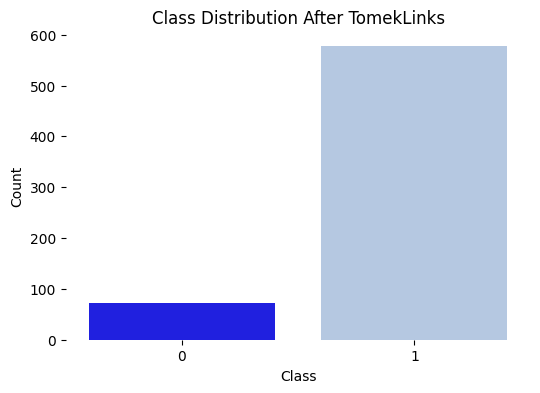

/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The TomekLinks or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The TomekLinks or classes from which it inherits use `_get_tags` and `_more_tags`. Please define


### BorderlineSMOTE ###
Data sebelum BorderlineSMOTE: [ 73 587]


<ipython-input-42-a20bced02bfd>:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=classes, y=counts, palette=colors)


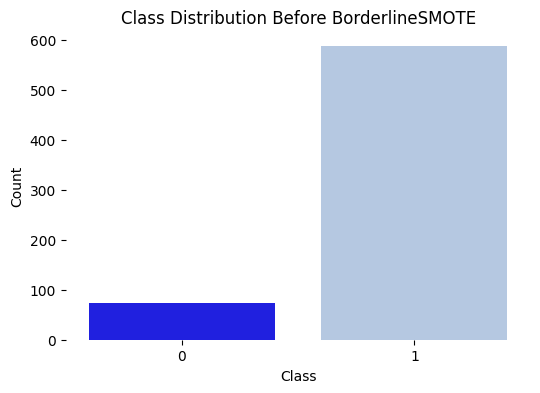

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The BorderlineSMOTE or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
<ipython-input-42-a20bced02bfd>:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` 

Data setelah BorderlineSMOTE: [587 587]


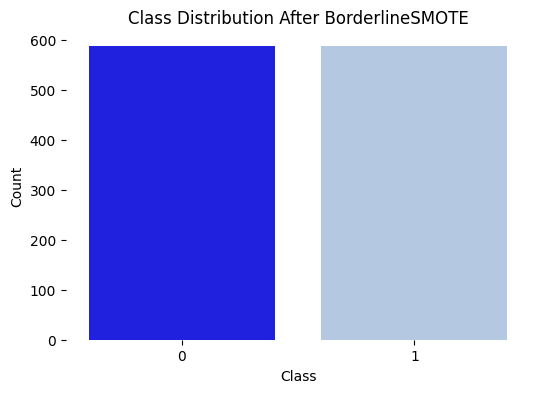

/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The BorderlineSMOTE or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The BorderlineSMOTE or classes from which it inherits use `_get_tags` and `_more_tags`. Ple


### Condensed Nearest Neighbors (CNN) ###
Data sebelum CNN: [ 73 587]


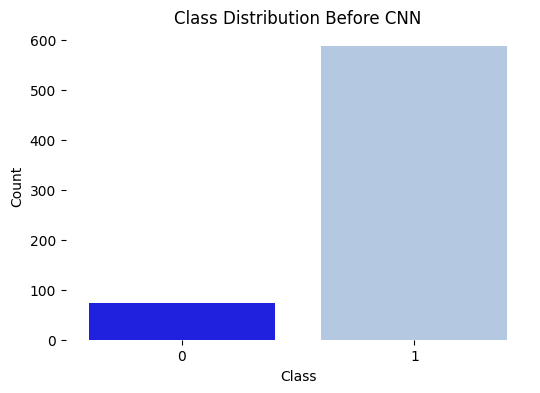

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The CondensedNearestNeighbour or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


Data setelah CNN: [73 54]


<ipython-input-42-a20bced02bfd>:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=classes, y=counts, palette=colors)


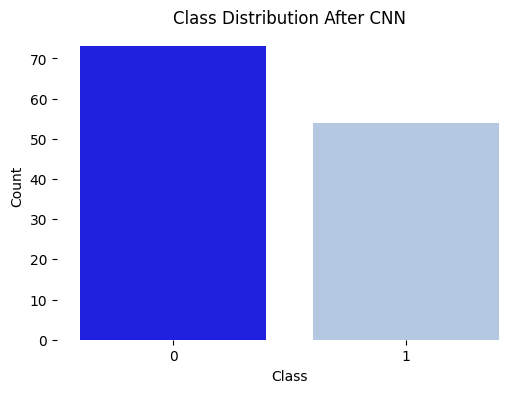

/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The CondensedNearestNeighbour or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The CondensedNearestNeighbour or classes from which it inherits use `_get_tags` a


### Without Resampling ###
Distribusi kelas pada data asli: [ 73 587]


<ipython-input-42-a20bced02bfd>:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=classes, y=counts, palette=colors)


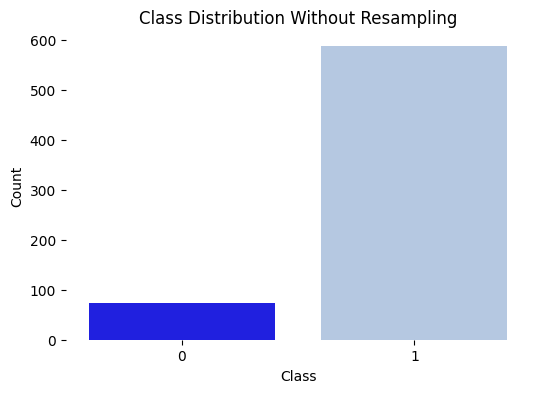


### Evaluation Results ###
                Model  Accuracy  Precision    Recall  F1 Score
0         SMOTE-Tomek  0.987952   0.986207  1.000000  0.993056
1            SMOTEENN  0.987952   1.000000  0.986014  0.992958
2             SMOTENC  0.987952   0.986207  1.000000  0.993056
3          TomekLinks  0.981928   0.979452  1.000000  0.989619
4     BorderlineSMOTE  0.987952   0.986207  1.000000  0.993056
5                 CNN  0.981928   0.979452  1.000000  0.989619
6  Without Resampling  0.981928   0.979452  1.000000  0.989619


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
from imblearn.combine import SMOTETomek, SMOTEENN
from imblearn.over_sampling import SMOTENC, BorderlineSMOTE
from imblearn.under_sampling import TomekLinks, CondensedNearestNeighbour
from imblearn.pipeline import make_pipeline
import pandas as pd

# Simulasi data
# Pastikan X dan y sudah didefinisikan sebelumnya

# Data pembagian
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fungsi untuk visualisasi distribusi kelas dengan warna biru dan biru muda
def plot_class_distribution(y, title):
    classes, counts = np.unique(y, return_counts=True)
    plt.figure(figsize=(6, 4))

    # Palet warna biru dan biru muda
    colors = ['Blue', '#aec7e8']
    sns.barplot(x=classes, y=counts, palette=colors)

    plt.title(title)
    plt.xlabel("Class")
    plt.ylabel("Count")

    # Menghapus frame hitam
    ax = plt.gca()
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)

    # Menghapus grid
    plt.grid(False)
    plt.show()


# Fungsi evaluasi model
def evaluate_model(pipeline, X_test, y_test, title):
    y_pred = pipeline.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='binary')
    recall = recall_score(y_test, y_pred, average='binary')
    f1 = f1_score(y_test, y_pred, average='binary')

    results = {
        "Model": title,
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "F1 Score": f1
    }
    return results

# GridSearchCV parameter tuning
param_grid = {
    'randomforestclassifier__n_estimators': [50, 100, 150],
    'randomforestclassifier__max_depth': [10, 20, None],
    'randomforestclassifier__min_samples_split': [2, 5, 10]
}

# SMOTETomek
print("\n### SMOTE-Tomek ###")
print(f"Data sebelum SMOTE-Tomek: {np.bincount(y_train)}")  # Menampilkan distribusi sebelum resampling
plot_class_distribution(y_train, "Class Distribution Before SMOTE-Tomek")
smote_tomek = SMOTETomek(sampling_strategy='auto')  # Menggunakan sampling_strategy untuk menyeimbangkan data
X_resampled_tomek, y_resampled_tomek = smote_tomek.fit_resample(X_train, y_train)
print(f"Data setelah SMOTE-Tomek: {np.bincount(y_resampled_tomek)}")  # Menampilkan distribusi setelah resampling
plot_class_distribution(y_resampled_tomek, "Class Distribution After SMOTE-Tomek")

pipeline_tomek = make_pipeline(smote_tomek, RandomForestClassifier(random_state=42))
grid_search_tomek = GridSearchCV(pipeline_tomek, param_grid, cv=5, n_jobs=-1)
grid_search_tomek.fit(X_resampled_tomek, y_resampled_tomek)
smote_tomek_results = evaluate_model(grid_search_tomek.best_estimator_, X_test, y_test, "SMOTE-Tomek")

# Resampling menggunakan SMOTEENN
print("\n### SMOTEENN ###")
print(f"Data sebelum SMOTEENN: {np.bincount(y_train)}")  # Menampilkan distribusi sebelum resampling
plot_class_distribution(y_train, "Class Distribution Before Resampling Techniques")
smote_enn = SMOTEENN(sampling_strategy='auto')  # Menggunakan 'auto'
X_resampled_enn, y_resampled_enn = smote_enn.fit_resample(X_train, y_train)
print(f"Data setelah SMOTEENN: {np.bincount(y_resampled_enn)}")  # Menampilkan distribusi setelah resampling
plot_class_distribution(y_resampled_enn, "Class Distribution After SMOTEENN")

pipeline_enn = make_pipeline(smote_enn, RandomForestClassifier(random_state=42))
grid_search_enn = GridSearchCV(pipeline_enn, param_grid, cv=5, n_jobs=-1)
grid_search_enn.fit(X_resampled_enn, y_resampled_enn)
smote_enn_results = evaluate_model(grid_search_enn.best_estimator_, X_test, y_test, "SMOTEENN")

# Resampling menggunakan SMOTENC
print("\n### SMOTENC ###")
print(f"Data sebelum SMOTENC: {np.bincount(y_train)}")  # Menampilkan distribusi sebelum resampling
plot_class_distribution(y_train, "Class Distribution Before SMOTENC")
categorical_features = [0]  # Pastikan ini adalah indeks dari fitur kategori
smote_nc = SMOTENC(categorical_features=categorical_features, sampling_strategy='auto')  # Menggunakan 'auto'
X_resampled_nc, y_resampled_nc = smote_nc.fit_resample(X_train, y_train)
print(f"Data setelah SMOTENC: {np.bincount(y_resampled_nc)}")  # Menampilkan distribusi setelah resampling
plot_class_distribution(y_resampled_nc, "Class Distribution After SMOTENC")

pipeline_nc = make_pipeline(smote_nc, RandomForestClassifier(random_state=42))
grid_search_nc = GridSearchCV(pipeline_nc, param_grid, cv=5, n_jobs=-1)
grid_search_nc.fit(X_resampled_nc, y_resampled_nc)
smote_nc_results = evaluate_model(grid_search_nc.best_estimator_, X_test, y_test, "SMOTENC")

# Resampling menggunakan TomekLinks
print("\n### TomekLinks ###")
print(f"Data sebelum TomekLinks: {np.bincount(y_train)}")  # Menampilkan distribusi sebelum resampling
plot_class_distribution(y_train, "Class Distribution Before TomekLinks")
tomek_links = TomekLinks(sampling_strategy='majority')  # Undersampling pada kelas mayoritas
X_resampled_tl, y_resampled_tl = tomek_links.fit_resample(X_train, y_train)
print(f"Data setelah TomekLinks: {np.bincount(y_resampled_tl)}")  # Menampilkan distribusi setelah resampling
plot_class_distribution(y_resampled_tl, "Class Distribution After TomekLinks")

pipeline_tl = make_pipeline(tomek_links, RandomForestClassifier(random_state=42))
grid_search_tl = GridSearchCV(pipeline_tl, param_grid, cv=5, n_jobs=-1)
grid_search_tl.fit(X_resampled_tl, y_resampled_tl)
tomek_links_results = evaluate_model(grid_search_tl.best_estimator_, X_test, y_test, "TomekLinks")

# Resampling menggunakan BorderlineSMOTE
print("\n### BorderlineSMOTE ###")
print(f"Data sebelum BorderlineSMOTE: {np.bincount(y_train)}")  # Menampilkan distribusi sebelum resampling
plot_class_distribution(y_train, "Class Distribution Before BorderlineSMOTE")
borderline_smote = BorderlineSMOTE(sampling_strategy='auto')  # Menggunakan 'auto' untuk menyeimbangkan data
X_resampled_bs, y_resampled_bs = borderline_smote.fit_resample(X_train, y_train)
print(f"Data setelah BorderlineSMOTE: {np.bincount(y_resampled_bs)}")  # Menampilkan distribusi setelah resampling
plot_class_distribution(y_resampled_bs, "Class Distribution After BorderlineSMOTE")

pipeline_bs = make_pipeline(borderline_smote, RandomForestClassifier(random_state=42))
grid_search_bs = GridSearchCV(pipeline_bs, param_grid, cv=5, n_jobs=-1)
grid_search_bs.fit(X_resampled_bs, y_resampled_bs)
borderline_smote_results = evaluate_model(grid_search_bs.best_estimator_, X_test, y_test, "BorderlineSMOTE")

# Condensed Nearest Neighbors (CNN) for undersampling
print("\n### Condensed Nearest Neighbors (CNN) ###")
print(f"Data sebelum CNN: {np.bincount(y_train)}")  # Menampilkan distribusi sebelum undersampling
plot_class_distribution(y_train, "Class Distribution Before CNN")
cnn = CondensedNearestNeighbour(sampling_strategy='auto')  # Undersampling menggunakan CNN
X_resampled_cnn, y_resampled_cnn = cnn.fit_resample(X_train, y_train)
print(f"Data setelah CNN: {np.bincount(y_resampled_cnn)}")  # Menampilkan distribusi setelah resampling
plot_class_distribution(y_resampled_cnn, "Class Distribution After CNN")

pipeline_cnn = make_pipeline(cnn, RandomForestClassifier(random_state=42))
grid_search_cnn = GridSearchCV(pipeline_cnn, param_grid, cv=5, n_jobs=-1)
grid_search_cnn.fit(X_resampled_cnn, y_resampled_cnn)
cnn_results = evaluate_model(grid_search_cnn.best_estimator_, X_test, y_test, "CNN")

# Tanpa resampling
print("\n### Without Resampling ###")
print(f"Distribusi kelas pada data asli: {np.bincount(y_train)}")  # Menampilkan distribusi asli
plot_class_distribution(y_train, "Class Distribution Without Resampling")

pipeline_no_resampling = make_pipeline(RandomForestClassifier(random_state=42))
grid_search_no_resampling = GridSearchCV(pipeline_no_resampling, param_grid, cv=5, n_jobs=-1)
grid_search_no_resampling.fit(X_train, y_train)
no_resampling_results = evaluate_model(grid_search_no_resampling.best_estimator_, X_test, y_test, "Without Resampling")

# Gabungkan hasil evaluasi dalam satu tabel
results = pd.DataFrame([smote_tomek_results, smote_enn_results, smote_nc_results, tomek_links_results, borderline_smote_results, cnn_results, no_resampling_results])
print("\n### Evaluation Results ###")
print(results)


Gambar disimpan sebagai confusion_matrix_no_resampling.png


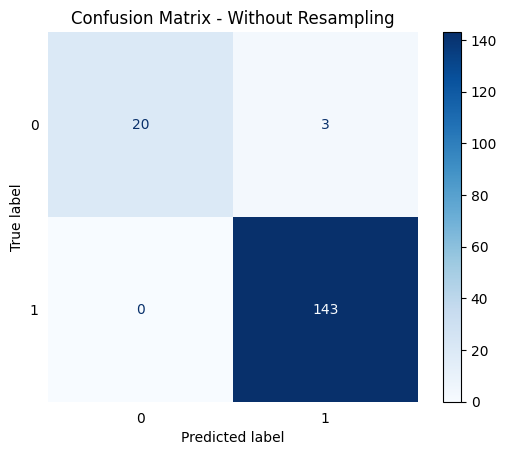

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The BorderlineSMOTE or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


Gambar disimpan sebagai confusion_matrix_borderline_smote.png


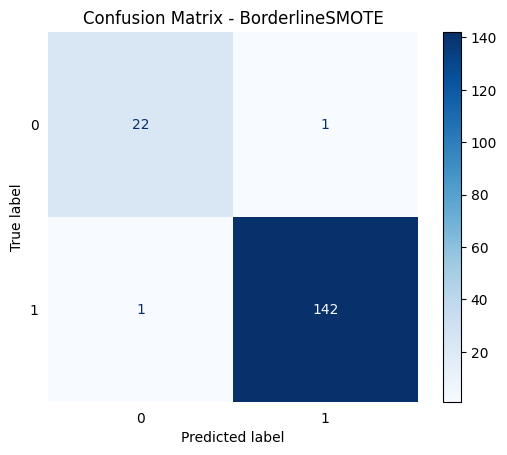

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The SMOTEENN or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.valida

Gambar disimpan sebagai confusion_matrix_smote_enn.png


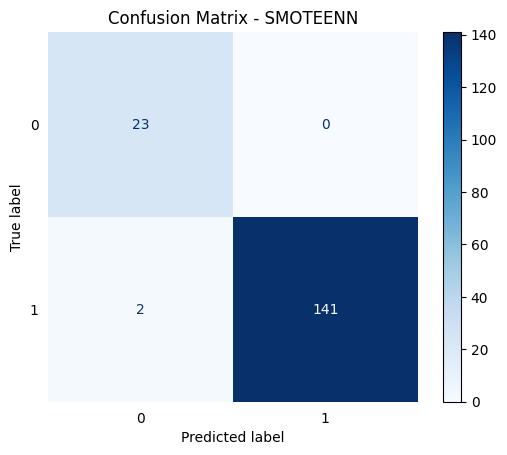

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The CondensedNearestNeighbour or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


Gambar disimpan sebagai confusion_matrix_cnn.png


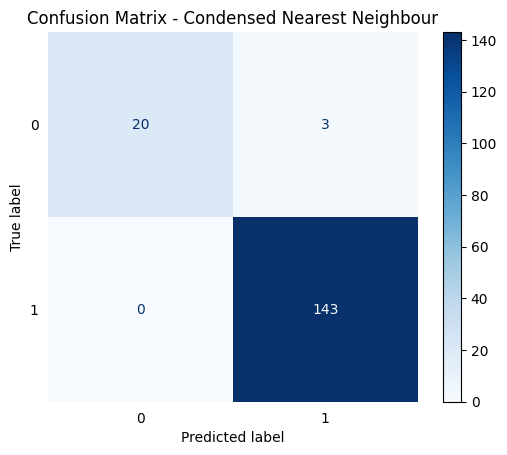


### Evaluation Results ###
                         Model  Accuracy  Precision    Recall  F1 Score
0           Without Resampling  0.981928   0.979452  1.000000  0.989619
1              BorderlineSMOTE  0.987952   0.993007  0.993007  0.993007
2                     SMOTEENN  0.987952   1.000000  0.986014  0.992958
3  Condensed Nearest Neighbour  0.981928   0.979452  1.000000  0.989619


In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, precision_score, recall_score, f1_score

# Fungsi untuk menampilkan confusion matrix tanpa frame hitam dan menyimpannya
def plot_confusion_matrix(y_true, y_pred, title, filename=None):
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap='Blues')

    # Menghapus frame hitam
    if disp.ax_:
        for spine in disp.ax_.spines.values():
            spine.set_visible(False)

        # Menghapus ticks (garis kecil di sumbu)
        disp.ax_.tick_params(left=False, bottom=False)

    plt.title(title)
    plt.gca().patch.set_visible(False)  # Menghapus background plot

    # Simpan gambar jika filename diberikan
    if filename:
        plt.savefig(filename, bbox_inches='tight', dpi=300)
        print(f"Gambar disimpan sebagai {filename}")

    plt.show()

# Fungsi evaluasi model dengan confusion matrix
def evaluate_model_with_cm(pipeline, X_test, y_test, title, filename=None):
    y_pred = pipeline.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='binary')
    recall = recall_score(y_test, y_pred, average='binary')
    f1 = f1_score(y_test, y_pred, average='binary')

    # Menampilkan confusion matrix dan menyimpannya jika filename diberikan
    plot_confusion_matrix(y_test, y_pred, f"Confusion Matrix - {title}", filename)

    results = {
        "Model": title,
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "F1 Score": f1
    }
    return results

# Evaluasi semua metode
evaluation_results = []

# Without Resampling
pipeline_no_resampling.fit(X_train, y_train)
no_resampling_results = evaluate_model_with_cm(pipeline_no_resampling, X_test, y_test, "Without Resampling", "confusion_matrix_no_resampling.png")
evaluation_results.append(no_resampling_results)

# BorderlineSMOTE
pipeline_bs.fit(X_resampled_bs, y_resampled_bs)
borderline_smote_results = evaluate_model_with_cm(pipeline_bs, X_test, y_test, "BorderlineSMOTE", "confusion_matrix_borderline_smote.png")
evaluation_results.append(borderline_smote_results)

# SMOTEENN
pipeline_enn.fit(X_resampled_enn, y_resampled_enn)
smote_enn_results = evaluate_model_with_cm(pipeline_enn, X_test, y_test, "SMOTEENN", "confusion_matrix_smote_enn.png")
evaluation_results.append(smote_enn_results)

# Condensed Nearest Neighbour
pipeline_cnn.fit(X_resampled_cnn, y_resampled_cnn)
cnn_results = evaluate_model_with_cm(pipeline_cnn, X_test, y_test, "Condensed Nearest Neighbour", "confusion_matrix_cnn.png")
evaluation_results.append(cnn_results)

# Gabungkan hasil evaluasi dalam satu tabel
results = pd.DataFrame(evaluation_results)
print("\n### Evaluation Results ###")
print(results)




In [ ]:
!python --version



Python 3.10.12


## Modeling

### Model Fit & Predict

## Evaluation